In [19]:
# Modules for structuring text
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph modules for defining graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Module for setting up OpenAI
# from langchain_openai import ChatOpenAI



In [20]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

## Building graph and agent states


In [21]:
# Define the State
class State(TypedDict):
    # Define messages with metadata    
    messages: Annotated[list, add_messages]
# Initialize StateGraph
graph_builder = StateGraph(State)


Adding nodes and edges

In [22]:
# Define chatbot function to respond# with the model
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages":  [response]}
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

## Connect the graph nodes: START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()


In [23]:
graph.invoke({"messages": ["Hello, how are you?"]})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='15783d1c-eae0-43d7-8322-fcbbd137fd96'),
  AIMessage(content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--d3177566-93a0-4cde-a278-5d4d90991284-0', usage_metadata={'input_tokens': 6, 'output_tokens': 50, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})]}

## Streaming LLM responses


In [24]:
def stream_graph_updates(user_input: str):
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"], end="|")

# Define the user query and run the chatbot
user_query = "Who is Dinh Trung Thao?"
stream_graph_updates(user_query)

Agent: [AIMessage(content="Dinh Trung Thao is a Vietnamese politician. He is currently the Vice Chairman of the Standing Committee of the National Assembly of Vietnam. He is also a member of the Communist Party of Vietnam's Central Committee.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c3f593ce-261a-4ae1-b990-ff8f57fd50c0-0', usage_metadata={'input_tokens': 8, 'output_tokens': 44, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}})]|

## Generate a LangGraph diagram


In [25]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")


KeyboardInterrupt: 

# Adding external tools to a chatbot

Adding a Wikipedia tool

In [26]:
%pip install wikipedia
%pip install langchain-community

from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# Initialize Wikipedia API wrapper to fetch top 1 result
api_wrapper = WikipediaAPIWrapper(top_k_results=1)
# Create a Wikipedia query tool using the API wrapper

wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
tools = [wikipedia_tool]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Bind the Wikipedia tool to 
# the language model
llm_with_tools = llm.bind_tools(tools)

# Modify chatbot function to # respond with Wikipedia
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

## Adding tool nodes



In [28]:
#Modules for adding tool conditions # and nodes
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

In [29]:
# Create a ToolNode to handle tool calls # and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

In [30]:
# Set up a condition to direct from chatbot to tool or end node
graph_builder.add_conditional_edges("chatbot", tools_condition)

In [31]:
# Connect tools back to chatbot and  # add START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [32]:
graph = graph_builder.compile()

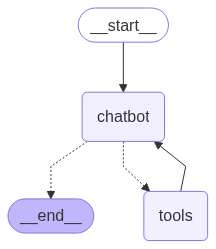

In [33]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")


In [ ]:
def stream_tool_responses(user_input: str):
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"], end="|")

In [ ]:
user_query = "House of Lords"
stream_tool_responses(user_query)


Agent: [AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "House of Lords"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9c6ce07d-a571-4593-a0e1-1fa248bce87c-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'House of Lords'}, 'id': '0d093214-8006-4e77-93d0-03a4a498f9ee', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 5, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})]|Agent: [ToolMessage(content='Page: House of Lords\nSummary: The House of Lords is the upper house of the Parliament of the United Kingdom. Like the lower house, the House of Commons, it meets in the Palace of Westminster in London, England. One of the oldest extant institutions in the world, its origins lie in the early 11th century and the emergence of bicameralism in the 13th century.\nIn

## Adding memory

In [ ]:
# # Import the modules for saving memory
# from langgraph.checkpoint.memory import MemorySaver
# # Modify the graph with memory checkpointing
# memory = MemorySaver()  # Compile the graph passing in memory
# graph = graph_builder.compile(checkpointer=memory)
